<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_1704_feature_engineering_03_feature_selection_07_unsupervised_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Descriptions of Unsupervised Methods for Feature Selection

### 1. **Principal Component Analysis (PCA):**
   - **Assumptions:** PCA assumes that the relationships between features are **linear**.
   - **Goal:** PCA seeks to maximize the variance captured in fewer dimensions. The idea is that by capturing the directions of maximum variance, we can represent the dataset with fewer components while retaining most of the information.
   - **How It Works:** PCA finds the axes (principal components) that explain the most variance in the data and uses them to project the data into a lower-dimensional space.
   - **Focus:** Variance is key—PCA prioritizes directions in which the data is spread out the most, without considering correlations or groupings.

### 2. **Factor Analysis (FA):**
   - **Assumptions:** Like PCA, FA assumes **linear** relationships between features.
   - **Goal:** FA focuses on identifying underlying **latent factors** that are responsible for the correlations observed among the features. The idea is that the variability in many features can be explained by a smaller number of hidden factors.
   - **How It Works:** FA models the observed variables as linear combinations of potential latent factors, focusing on capturing shared variance (correlations) rather than total variance.
   - **Focus:** Correlations and groupings—FA tries to uncover hidden structures (latent factors) that explain why certain groups of features are correlated.

### 3. **Autoencoders:**
   - **Assumptions:** Autoencoders do **not** assume linear relationships, making them more flexible and capable of modeling complex, non-linear patterns.
   - **Goal:** Autoencoders aim to extract the most important information from the data, regardless of its distribution. They do this by learning a compressed (latent) representation of the data and then reconstructing the original input as closely as possible.
   - **How It Works:** Autoencoders use neural networks with an encoder-decoder structure. The encoder compresses the input, and the decoder reconstructs it. The model is trained to minimize the difference between the input and the reconstructed output.
   - **Focus:** Information extraction—autoencoders learn representations that capture essential features, even if the relationships between them are non-linear.

### Summary Comparison:
- **PCA** assumes linearity and focuses on maximizing variance, aiming to reduce dimensionality by capturing the directions where the data varies the most.
- **Factor Analysis** also assumes linearity but emphasizes correlations, aiming to uncover hidden factors that explain why certain features are related.
- **Autoencoders** do not assume linearity and aim to learn rich representations by compressing the data and reconstructing it, making them effective for capturing both linear and non-linear patterns.


## Baseline Performance

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import cross_val_score
import json
import warnings
from loan_data_utils import load_and_preprocess_data, plot_classification_report_metrics, ThresholdClassifier, plot_selected_features, save_experiment_results
from loan_data_feature_engineering import *

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Define your URL, categorical columns, and target
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'marriage', 'education']
target = 'default_payment_next_month'

# Load and preprocess data
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = ['sex', 'marriage']
# Define the custom ordering for the 'education' variable as ordered category
education_order = [0, 1, 2, 3, 4, 5, 6]

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('education_ord', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('ordinal_encoder', OrdinalEncoder(categories=[education_order]))
        ]), ['education']),  # Treat education separately with ordinal encoding
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_columns)
    ])

# Fit and transform the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE after preprocessing
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_preprocessed, y_train)

# Use the custom classifier with Logistic Regression and a threshold of 0.3 for class 1
base_classifier = LogisticRegression(max_iter=5000)
classifier = ThresholdClassifier(base_classifier, threshold=0.3)

# Train the classifier on the resampled data
classifier.fit(X_train_res, y_train_res)

# Predict and evaluate on the preprocessed test set
y_pred = classifier.predict(X_test_preprocessed)
baseline_report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))

# Initialize a dictionary to store the classification reports
experiment_results = {}
selected_features = {}

# Add the baseline report to the dictionary
experiment_results['baseline'] = baseline_report

# Define the path and filename for the JSON file
json_filename = 'classification_reports_unsupervised_methods.json'

# Save the baseline report to the JSON file using the new unified function
save_experiment_results(experiment_results, selected_features, json_filename)

              precision    recall  f1-score   support

           0       0.88      0.24      0.38      4673
           1       0.25      0.88      0.39      1327

    accuracy                           0.38      6000
   macro avg       0.56      0.56      0.38      6000
weighted avg       0.74      0.38      0.38      6000

Experiment results saved to classification_reports_unsupervised_methods.json


## Feature Engineering Model

Dropping the original columns after binning is generally a good approach if the binned versions capture the information you need. However, it’s important to consider a few factors:

### Potential Issues to Consider:

1. **Loss of Detailed Information**:
   - Binning transforms continuous variables into discrete categories, which can lead to some loss of information. For example, specific nuances in the original continuous values might be lost when aggregated into bins.

2. **Impact on Model Performance**:
   - Some models, especially linear models, may perform better with the original continuous features compared to binned categories. Dropping the original continuous features could impact performance, so it’s important to validate this with experiments.

3. **Interaction with Other Features**:
   - If your feature engineering pipeline relies on interactions between the original features and others, dropping the original columns might cause issues or lead to unintended consequences.

### When It’s a Good Idea:
- **Simplified Features**: If the binned versions are more interpretable and simplify the model without significantly impacting performance.
- **Reducing Multicollinearity**: If the original continuous features are highly correlated with other features, replacing them with their binned versions can help reduce multicollinearity.

### Suggested Approach:
You can implement a solution where you drop the original features after binning and validate whether this approach benefits model performance:

### How to Proceed:
1. **Test Performance**: Run experiments comparing the performance of your model with and without the original continuous features.
2. **Validate Interpretability**: Determine whether the binned features still provide useful insights or if dropping the original features leads to a significant loss of information.

If dropping the original features after binning maintains or improves performance, this approach could simplify your model while retaining the key information from the features. Let me know if you need further assistance!

In [4]:
# Get the feature names from the preprocessor
numeric_feature_names = numeric_features
ordinal_feature_names = ['education']  # Since it's now processed as an ordinal category
onehot_feature_names = list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_columns))

# Combine the feature names
all_feature_names = numeric_feature_names + ordinal_feature_names + onehot_feature_names

# Convert the preprocessed data to DataFrames with the correct feature names
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

# Define your custom interaction pairs
interaction_pairs = [
    ('limit_bal', 'age'),
    ('limit_bal', 'pay_1'),
    ('limit_bal', 'pay_2'),
    ('bill_amt1', 'pay_amt1'),
    ('marriage_1', 'pay_1'),
    ('education_5', 'pay_1'),
    ('sex_2', 'pay_1'),
    ('marriage_1', 'pay_2'),
    ('sex_2', 'marriage_2'),
]

# Step 1: Apply Interaction Features First
interaction_pipeline = Pipeline(steps=[
    ('interaction', CustomInteractionFeatures(interaction_pairs=interaction_pairs))
])

# Step 2: Then Apply Feature Engineering Pipeline
features_to_bin = ['bill_amt1', 'pay_amt1', 'limit_bal']

feature_engineering_pipeline = Pipeline(steps=[
    ('ratio', RatioFeatures()),
    ('binning', SelectiveBinningFeaturesOneHot(features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=False))
])

# Combine Interaction Pipeline with the Feature Engineering Pipeline
full_pipeline = Pipeline(steps=[
    ('interaction', interaction_pipeline),
    ('feature_engineering', feature_engineering_pipeline)
])

# Apply the full pipeline to the training data
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Apply SMOTE after feature engineering
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_fe, y_train)

# Now you can proceed with model training
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_res, y_train_res)

# Evaluate on the test set
y_pred_fe = classifier.predict(X_test_fe)
fe_report = classification_report(y_test, y_pred_fe, output_dict=True)
print(classification_report(y_test, y_pred_fe))

# Add the current experiment report to the dictionary
experiment_results['feature_engineering'] = fe_report

# Save the updated experiment results to the JSON file using the new unified function
save_experiment_results(experiment_results, selected_features, json_filename)


              precision    recall  f1-score   support

           0       0.88      0.78      0.82      4673
           1       0.44      0.62      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.70      0.67      6000
weighted avg       0.78      0.74      0.76      6000

Experiment results saved to classification_reports_unsupervised_methods.json


In [ ]:
# Check for NaNs before feature engineering
print("NaN values before feature engineering:")
print(X_train_preprocessed_df[features_to_bin].isnull().sum())

# Apply Feature Engineering Pipeline
X_train_fe = full_pipeline.fit_transform(X_train_preprocessed_df)
X_test_fe = full_pipeline.transform(X_test_preprocessed_df)

# Convert back to DataFrame for easier inspection
X_train_fe_df = pd.DataFrame(X_train_fe, columns=all_feature_names)
X_test_fe_df = pd.DataFrame(X_test_fe, columns=all_feature_names)

# Check for NaNs after feature engineering
print("NaN values after feature engineering:")
print(X_train_fe_df[features_to_bin].isnull().sum())


NaN values before feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64
NaN values after feature engineering:
bill_amt1    0
pay_amt1     0
limit_bal    0
dtype: int64


### Principal Component Analysis (PCA)

**What It Is:**
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space. It identifies the directions (called principal components) along which the variance in the data is maximized.

**What It Tries to Achieve:**
PCA aims to reduce the complexity of the data while retaining as much information as possible. By selecting the principal components that explain the most variance, PCA helps in simplifying the dataset without losing significant information.

**How It Works:**
- PCA calculates the principal components as new axes for the data, based on the direction of maximum variance.
- It ranks these components by the amount of variance they capture.
- You can then project the data onto a lower-dimensional space using the top-ranked components (e.g., the first few components that explain 95% of the variance).

**Strengths:**
- **Dimensionality Reduction:** Reduces the number of features, leading to faster computation and reducing the risk of overfitting.
- **Feature Decorrelation:** Removes correlations between features by projecting data onto uncorrelated axes.
- **Visualization:** In some cases, PCA allows you to visualize high-dimensional data in 2D or 3D.

**Weaknesses:**
- **Interpretability:** The principal components are linear combinations of the original features and may not be easily interpretable.
- **Linear Technique:** PCA assumes linear relationships between variables, which may not capture complex patterns in data.
- **Sensitivity to Scaling:** PCA is sensitive to the scaling of features, so it usually requires standardized data.

**When to Use It:**
- When you have a large number of features and want to reduce dimensionality while preserving most of the information.
- When you want to eliminate multicollinearity or explore the data for feature selection.
- When you need to visualize high-dimensional data in a simpler space.


### Understanding the Direction of Maximum Variance

**What is Variance?**
Variance measures how much the data points in a dataset deviate from the mean. In simpler terms, it tells you how spread out the data is. In a 2D plot, variance can be thought of as how much the points spread out along the X-axis or Y-axis.

**Why Does Variance Matter in PCA?**
PCA is interested in finding new axes (directions) that best capture the spread of the data. The idea is that the directions where the data varies the most are likely to hold the most information about the underlying structure of the dataset. The goal is to project the data onto these directions to reduce the dimensionality while preserving as much variability (information) as possible.

**Principal Components and Maximum Variance:**
- The first principal component is the direction in which the data shows the most variance. In other words, it’s the axis along which the data is most spread out.
- The second principal component is orthogonal (perpendicular) to the first and captures the next highest variance in the data, and so on.

Let’s break it down further with a simple analogy.

### Analogy: Finding the Best View of a Data Cloud

Imagine you have a cloud of points floating in 3D space. If you look at this cloud from different angles, the amount of spread (variance) you see will change depending on your viewpoint.

- **Best View (First Principal Component):** Suppose you find a view where the points appear most spread out. This view aligns with the first principal component, the direction of maximum variance. It captures the broadest spread of points.

- **Next Best View (Second Principal Component):** Now, imagine looking at the cloud from a different angle, perpendicular to the first. You still want to see as much spread as possible, but now you’re looking for the spread that isn’t captured by the first view. This direction is the second principal component.

Each principal component you find represents a direction where the data shows significant variance, and each subsequent component is orthogonal (perpendicular) to the others, capturing progressively less variance.

### Why Does PCA Focus on Maximum Variance?

Maximizing variance helps PCA in two ways:
1. **Information Retention:** By focusing on directions of maximum variance, PCA ensures that most of the important information (variation) in the dataset is preserved.
2. **Dimensionality Reduction:** Once PCA identifies these principal components, you can often keep only the first few components, discarding the rest. This allows you to reduce the dimensionality of the data while still retaining most of the information.


## PCA for Continuous Data

Categorical data, once one-hot encoded, can’t be used with methods like PCA and Factor Analysis. Technically, you **can** apply these methods to one-hot encoded categorical data, but the effectiveness and interpretation of the results can be problematic. Let’s break down the reasoning:

### Why PCA and Factor Analysis May Not Be Ideal for One-Hot Encoded Data:

1. **Nature of One-Hot Encoded Data:**
    - One-hot encoding creates binary columns (0s and 1s) for each category.
    - PCA and Factor Analysis are designed to capture linear relationships and continuous variance. They assume the input features are continuous and linearly related.

2. **Variance in One-Hot Encoded Data:**
    - In one-hot encoded columns, most values are 0, with only a few 1s scattered across the rows. This sparse structure makes it hard for methods like PCA or Factor Analysis to capture meaningful variance, leading to components that don’t add much value.

3. **Interpretation Issues:**
    - When PCA or Factor Analysis reduces dimensionality, it combines features into principal components or latent factors. For one-hot encoded data, these components might mix categories in ways that are hard to interpret or make little logical sense.

4. **Loss of Categorical Meaning:**
    - By mixing binary indicators from one-hot encoding, the reduced features lose their original categorical meaning, making the results difficult to understand.

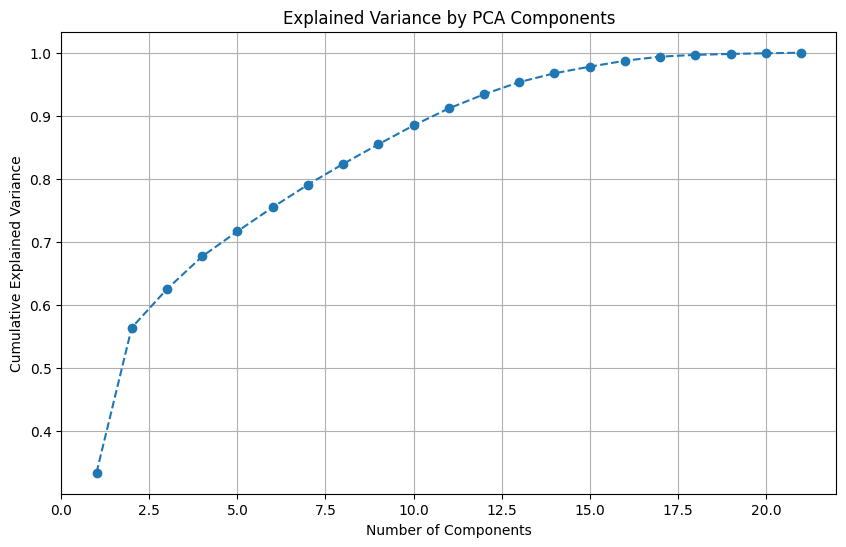

Optimal number of components: 13
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4673
           1       0.44      0.61      0.51      1327

    accuracy                           0.74      6000
   macro avg       0.66      0.69      0.67      6000
weighted avg       0.78      0.74      0.75      6000

Experiment results saved to classification_reports_unsupervised_methods.json


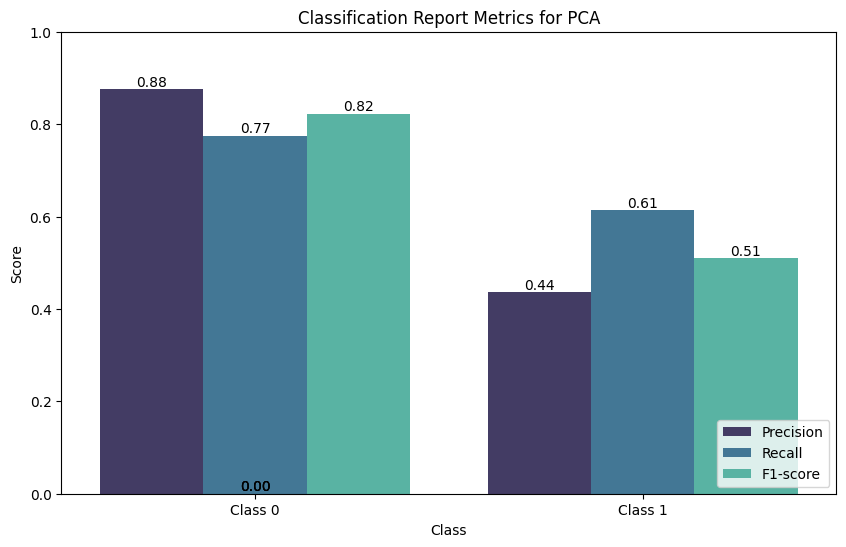

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from loan_data_utils import plot_classification_report_metrics, save_experiment_results

# Step 1: Apply the full feature engineering pipeline and SMOTE (already done)
# X_train_fe, X_test_fe, X_train_res, y_train_res are assumed to be already processed and available

# Step 2: Select numeric columns and the ordinal 'education' column for PCA
numeric_and_ordinal_columns = numeric_features + ['education']

# Step 3: Perform PCA on the numeric and ordinal features
pca = PCA()
X_train_numeric = X_train_res[numeric_and_ordinal_columns]
X_test_numeric = X_test_fe[numeric_and_ordinal_columns]

# Fit PCA on the resampled numeric and ordinal training data
pca.fit(X_train_numeric)

# Plot the explained variance to choose the number of components
explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Select the number of components that explain at least 95% of the variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Optimal number of components: {n_components}')

# Step 4: Transform the numeric and ordinal data using the selected PCA components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_numeric)
X_test_pca = pca.transform(X_test_numeric)

# Convert the PCA components to DataFrames
X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'pca_{i}' for i in range(X_train_pca.shape[1])])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'pca_{i}' for i in range(X_test_pca.shape[1])])

# Step 5: Recombine the PCA components with the remaining (non-numeric) features
X_train_final = pd.concat([X_train_pca_df, X_train_res.drop(columns=numeric_and_ordinal_columns).reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_pca_df, X_test_fe.drop(columns=numeric_and_ordinal_columns).reset_index(drop=True)], axis=1)

# Step 6: Train the final model
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_final, y_train_res)

# Step 7: Evaluate on the test set
y_pred_pca = classifier.predict(X_test_final)
classification_report_pca = classification_report(y_test, y_pred_pca, output_dict=True)
print(classification_report(y_test, y_pred_pca))

# Add the current experiment report to the dictionary
experiment_results = {'PCA': classification_report_pca}

# Save the updated experiment results to the JSON file using the new unified function
save_experiment_results(experiment_results, {}, 'classification_reports_unsupervised_methods.json')

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_pca, 'PCA')


## Factor Analysis

### What is Factor Analysis?

Factor Analysis (FA) is a dimensionality reduction and feature extraction method, similar to PCA, but with a different goal. While PCA focuses on capturing the directions of maximum variance, FA is more interested in identifying the hidden factors (or latent variables) that explain the observed correlations among the variables in your dataset.

In essence, Factor Analysis tries to uncover the hidden structures (factors) that are driving the relationships between observed variables.

### Key Concepts in Factor Analysis

1. **Observed Variables vs. Latent Factors:**
   - **Observed Variables:** These are the measurable quantities you have in your dataset, such as "age," "income," or "education level."
   - **Latent Factors:** These are the unobserved, underlying variables that might influence multiple observed variables. For example, “socioeconomic status” might be a latent factor that affects both "income" and "education level."

2. **Factors:**
   - The primary goal of FA is to group variables that are correlated with each other into clusters. Each cluster is represented by a factor. A factor is an abstract concept (like "intelligence" or "socioeconomic status") that influences several observed variables.

3. **Factor Loadings:**
   - Factor loadings represent the extent to which each observed variable is influenced by the latent factors. High loadings indicate that a variable is strongly associated with a particular factor.

4. **Communality:**
   - Communality measures how much of a variable’s variance is explained by the factors. If a variable’s communality is high, it suggests that the latent factors account for most of its behavior.

### How Does Factor Analysis Work?

1. **Identify the Correlations:**
   FA begins by analyzing the correlation matrix of your dataset. It tries to explain these correlations in terms of a few latent factors.

2. **Extract the Factors:**
   The method estimates a small number of factors that explain the observed correlations. Each factor is a linear combination of the original variables.

3. **Rotation (Optional but Common):**
   To make the factors easier to interpret, a technique called rotation is often applied. There are different types of rotation (e.g., Varimax), and they help in clarifying which variables load strongly onto which factors.

4. **Interpreting the Results:**
   After the analysis, each factor is associated with certain observed variables. You then interpret these factors as hidden drivers or themes that are influencing your dataset.

### Example to Illustrate Factor Analysis

Imagine you have a dataset with these variables: "income," "education level," "job satisfaction," and "housing quality." Factor Analysis might reveal that:

- **Factor 1:** "Socioeconomic Status" – This factor influences both "income" and "education level."
- **Factor 2:** "Quality of Life" – This factor influences "job satisfaction" and "housing quality."

In this example, instead of focusing on individual variables, you now have insight into two broader factors that capture much of the variance in the dataset.

### Strengths and Weaknesses of Factor Analysis

**Strengths:**
- **Latent Structure Identification:** FA helps in uncovering hidden relationships and structures in your data.
- **Data Reduction:** By focusing on a few factors, FA reduces the complexity of your dataset while retaining essential information.
- **Interpretability:** FA is particularly valuable when you want to interpret underlying dimensions (factors) that influence the observed data.

**Weaknesses:**
- **Assumptions:** FA assumes that the underlying factors are linear combinations of the variables and that the relationships are driven by these latent factors.
- **Requires Correlation:** FA works best when the variables are correlated. If your variables are mostly independent, FA might not be very informative.
- **Complexity in Interpretation:** The interpretation of factors and loadings can be subjective, especially when the relationships are not clear-cut.

### When to Use Factor Analysis

Factor Analysis is particularly useful when:
- You want to uncover hidden themes or factors that explain patterns in your data.
- Your data is multidimensional, and you suspect that a few underlying factors are driving the relationships.
- You aim to reduce dimensionality while maintaining interpretability.

### Summary

Factor Analysis is a technique that aims to find hidden factors that explain the correlations among observed variables. Unlike PCA, which focuses on variance, FA is more concerned with understanding the structure behind the relationships in your dataset. It’s a powerful tool when you believe that a few latent variables are driving the complexity of your observed data.

Feature Engineered Data Columns: Index(['bill_amt1_bin_0', 'bill_amt1_bin_1', 'bill_amt1_bin_2',
       'bill_amt1_bin_3', 'bill_amt1_bin_4', 'pay_amt1_bin_0',
       'pay_amt1_bin_1', 'pay_amt1_bin_2', 'pay_amt1_bin_3', 'pay_amt1_bin_4',
       'limit_bal_bin_0', 'limit_bal_bin_1', 'limit_bal_bin_2',
       'limit_bal_bin_3', 'limit_bal_bin_4', 'limit_bal', 'age', 'pay_1',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'education',
       'sex_2', 'marriage_1', 'marriage_2', 'marriage_3', 'limit_bal_age',
       'limit_bal_pay_1', 'limit_bal_pay_2', 'bill_amt1_pay_amt1',
       'marriage_1_pay_1', 'education_5_pay_1', 'sex_2_pay_1',
       'marriage_1_pay_2', 'sex_2_marriage_2', 'bill_ratio', 'pay_ratio',
       'age_income_ratio'],
      dtype='object')
              precision    recall  f1-score   support

          

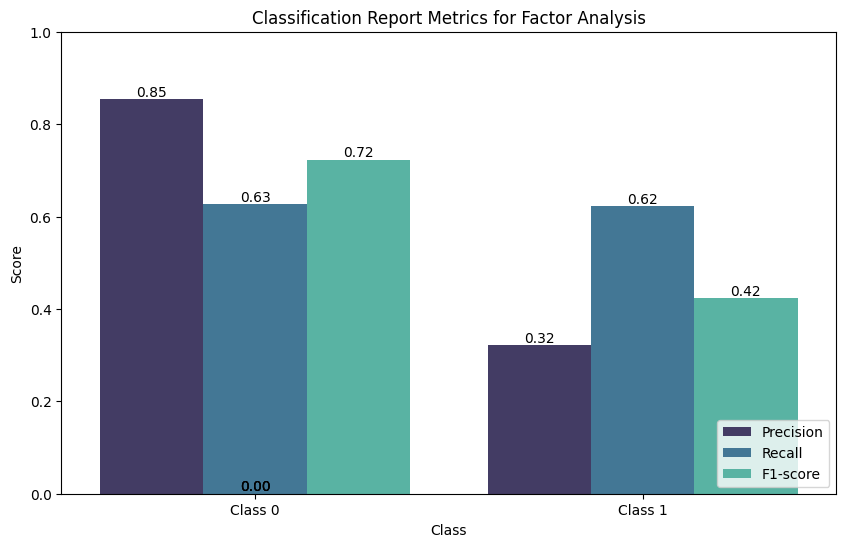

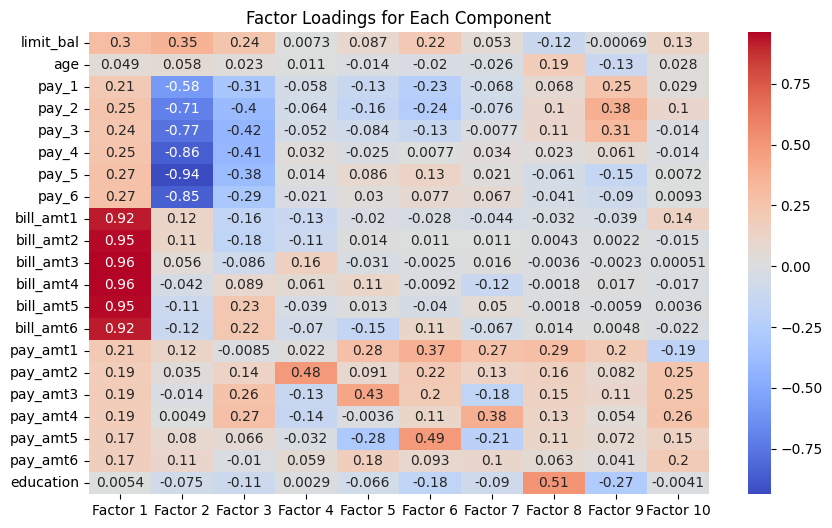

In [11]:
from sklearn.decomposition import FactorAnalysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the feature-engineered data back to DataFrames with the correct column names
feature_names_after_fe = full_pipeline.get_feature_names_out(all_feature_names)
X_train_fe_df = pd.DataFrame(X_train_fe, columns=feature_names_after_fe)
X_test_fe_df = pd.DataFrame(X_test_fe, columns=feature_names_after_fe)

# Debug: Check the columns after feature engineering
print("Feature Engineered Data Columns:", X_train_fe_df.columns)

# Step 1: Filter the numeric and ordinal columns, including the ordinal 'education' feature
numeric_and_ordinal_features = [col for col in feature_names_after_fe if col in numeric_features + ['education']]

# Select only these columns from the feature-engineered dataset after SMOTE
X_train_res_numeric = pd.DataFrame(X_train_res, columns=feature_names_after_fe)[numeric_and_ordinal_features]
X_test_fe_numeric = X_test_fe_df[numeric_and_ordinal_features]

# Step 2: Apply Factor Analysis on the resampled numeric and ordinal data
n_components_fa = min(len(numeric_and_ordinal_features), 10)  # Select a reasonable number of components
fa = FactorAnalysis(n_components=n_components_fa, random_state=42)
X_train_fa_transformed = fa.fit_transform(X_train_res_numeric)
X_test_fa_transformed = fa.transform(X_test_fe_numeric)

# Step 3: Train the classifier on the transformed data
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_fa_transformed, y_train_res)

# Step 4: Evaluate on the test set
y_pred_fa = classifier.predict(X_test_fa_transformed)
classification_report_fa = classification_report(y_test, y_pred_fa, output_dict=True)
print(classification_report(y_test, y_pred_fa))

# Step 5: Save and plot the results
experiment_results['FactorAnalysis'] = classification_report_fa
save_experiment_results(experiment_results, selected_features, 'classification_reports_unsupervised_methods.json')
plot_classification_report_metrics(classification_report_fa, 'Factor Analysis')

# Optional: Plot the factor loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=numeric_and_ordinal_features, columns=[f'Factor {i+1}' for i in range(n_components_fa)])
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadings, annot=True, cmap='coolwarm')
plt.title('Factor Loadings for Each Component')
plt.show()


### Factor Loadings Analysis

Factor loadings are key to interpreting factor analysis. They show how much each observed variable contributes to the identified factors, which are latent variables representing underlying patterns in the data. In the context of your loan default analysis, with a focus on class 1 recall (i.e., correctly identifying defaults), here's how to interpret the factor loadings:

### General Interpretation Strategy

1. **High Absolute Loadings (Above 0.5):** These variables are strongly associated with a given factor and are key in understanding what that factor represents.
2. **Moderate Loadings (0.3-0.5):** These variables moderately contribute to the factor, providing additional context.
3. **Low Loadings (Below 0.3):** These variables have a weaker association with the factor and contribute less to its meaning.

### Steps to Interpret Your Factor Loadings

1. **Understand the Factors:**
   - Each factor represents a latent variable that explains the shared variance in a group of observed variables.
   - Factors can be understood by looking at which variables have high loadings on them. For example, if several payment status features (e.g., `pay_1`, `pay_2`, `pay_3`) load heavily on a factor, that factor might represent payment behavior.

2. **Relating Factors to Class 1 Recall:**
   - Since your focus is on class 1 recall, prioritize factors that capture the variance in features that are strongly related to default, such as `pay_1` through `pay_6` (historical payment behavior), `bill_amt` features (historical bill amounts), and `pay_amt` features (payment amounts).

### Specific Observations from Your Factor Loadings

#### Factor 1:
- **Variables with High Loadings:** `bill_amt1`, `bill_amt2`, `bill_amt3`, `bill_amt4`, `bill_amt5`, `bill_amt6`
- **Interpretation:** Factor 1 is strongly associated with bill amounts. It likely represents the overall credit usage pattern of a customer. Customers with consistently high bill amounts across several periods may indicate higher credit utilization, which is often associated with default risk.

#### Factor 2:
- **Variables with High Loadings:** `pay_1`, `pay_2`, `pay_3`, `pay_4`, `pay_5`, `pay_6`
- **Interpretation:** Factor 2 is heavily driven by payment status features. This factor likely represents payment delinquency history, which is a critical indicator of future default. Since your focus is class 1 recall, this factor is likely highly relevant.

#### Factor 3:
- **Variables with Moderate Loadings:** `pay_1`, `pay_2`, `pay_3`
- **Interpretation:** Factor 3 still relates to payment behavior but may capture subtler patterns or interactions among earlier payments.

#### Other Factors (4-10):
- These factors generally have lower loadings or involve mixed variables, making them less directly interpretable. They may capture more specific, less critical patterns.

### Key Takeaways for Class 1 Recall
1. **Factors 1 and 2** are likely most important for modeling loan defaults. Factor 1 captures credit usage, while Factor 2 captures payment history—both are closely tied to default risk.
2. **Feature Selection:** You could prioritize features that load highly on these two factors when designing your predictive model, especially since they relate directly to payment and bill behavior.

By focusing on the factors that align closely with default-related features, you can enhance your model's ability to recall class 1 (defaults) effectively.

### Factor Analysis Top 4 Factors

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      4673
           1       0.34      0.60      0.43      1327

    accuracy                           0.66      6000
   macro avg       0.60      0.64      0.59      6000
weighted avg       0.74      0.66      0.68      6000

Experiment results saved to classification_reports_unsupervised_methods.json


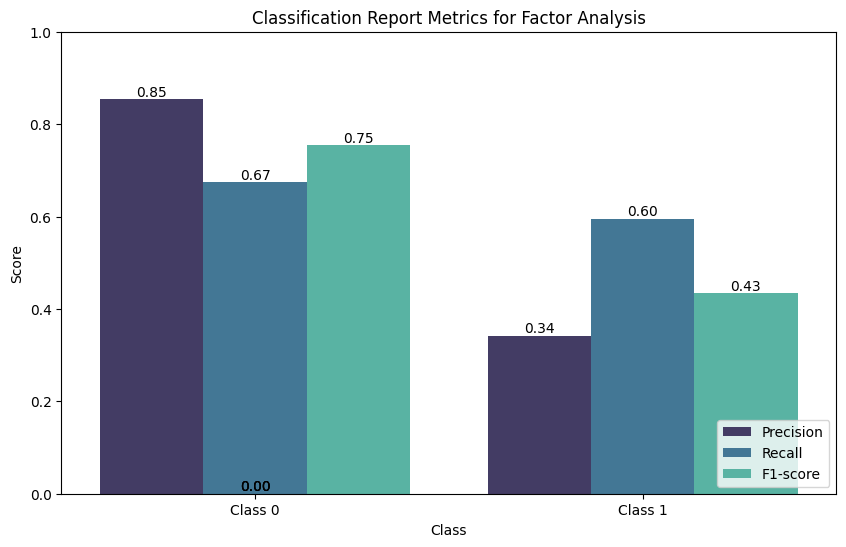

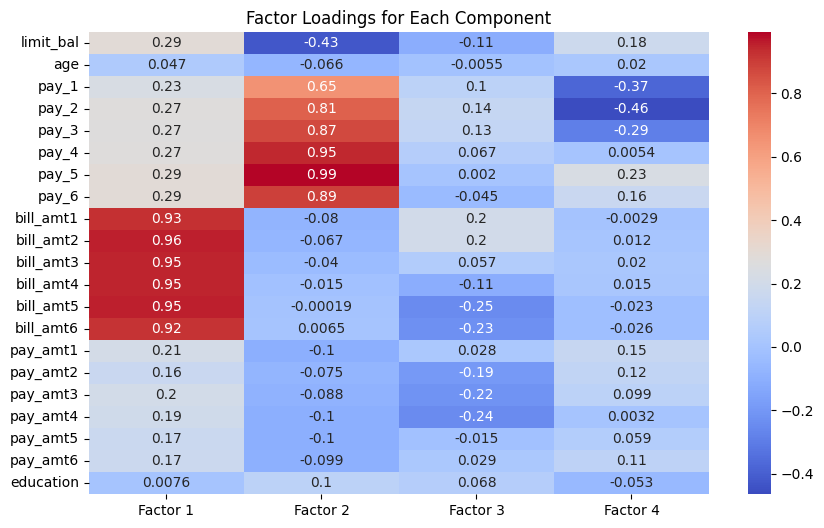

In [20]:
# Step 2: Apply Factor Analysis on the resampled numeric and ordinal data
n_components_fa = min(len(numeric_and_ordinal_features), 4)  # Select a reasonable number of components
fa = FactorAnalysis(n_components=n_components_fa, random_state=42)
X_train_fa_transformed = fa.fit_transform(X_train_res_numeric)
X_test_fa_transformed = fa.transform(X_test_fe_numeric)

# Step 3: Train the classifier on the transformed data
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_fa_transformed, y_train_res)

# Step 4: Evaluate on the test set
y_pred_fa = classifier.predict(X_test_fa_transformed)
classification_report_fa = classification_report(y_test, y_pred_fa, output_dict=True)
print(classification_report(y_test, y_pred_fa))

# Step 5: Save and plot the results
experiment_results['FactorAnalysis'] = classification_report_fa
save_experiment_results(experiment_results, selected_features, 'classification_reports_unsupervised_methods.json')
plot_classification_report_metrics(classification_report_fa, 'Factor Analysis')

# Optional: Plot the factor loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=numeric_and_ordinal_features, columns=[f'Factor {i+1}' for i in range(n_components_fa)])
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadings, annot=True, cmap='coolwarm')
plt.title('Factor Loadings for Each Component')
plt.show()

### Factor Analysis Top 4 Factors Model Evaluation

The classification reports indicate how well your model performs with 10 factors versus 4 factors in terms of precision, recall, and F1-score. Let's break down the key metrics and what they imply for your objective of prioritizing class 1 recall (identifying loan defaults).

### Key Metrics to Compare:
1. **Class 1 Recall (Primary Focus)**
2. **Class 1 Precision**
3. **Class 0 Performance (To Understand Trade-offs)**
4. **Overall Accuracy and Macro-Averaged Metrics**

### Analysis

#### 10 Factors:
- **Class 1 (Defaults):**
  - **Recall:** 0.62
  - **Precision:** 0.32
  - **F1-Score:** 0.42

- **Class 0 (Non-Defaults):**
  - **Recall:** 0.63
  - **Precision:** 0.85
  - **F1-Score:** 0.72

- **Overall Accuracy:** 0.63

#### 4 Factors:
- **Class 1 (Defaults):**
  - **Recall:** 0.60 (slightly lower)
  - **Precision:** 0.34 (slightly higher)
  - **F1-Score:** 0.43 (slightly higher)

- **Class 0 (Non-Defaults):**
  - **Recall:** 0.67 (better than with 10 factors)
  - **Precision:** 0.85 (same as with 10 factors)
  - **F1-Score:** 0.75 (better than with 10 factors)

- **Overall Accuracy:** 0.66 (better than with 10 factors)

### Interpretation

1. **Class 1 Recall:** The recall for class 1 (defaults) is slightly better with 10 factors (0.62) compared to 4 factors (0.60). Recall is your primary focus, so this suggests that using more factors helps identify more defaults. However, the improvement is marginal.

2. **Class 1 Precision:** Precision is slightly higher with 4 factors (0.34) compared to 10 factors (0.32). Higher precision means fewer false positives, which could be beneficial if false positives (incorrectly predicting defaults) are costly. The small improvement suggests that reducing factors may help in reducing noise.

3. **Class 0 Performance:** Class 0 (non-defaults) performance is notably better with 4 factors:
   - **Recall:** 0.67 vs. 0.63
   - **F1-Score:** 0.75 vs. 0.72
   This improvement indicates that the model is better at correctly identifying non-defaults with fewer factors.

4. **Overall Accuracy and Macro-Averaged Metrics:** The model’s overall accuracy is better with 4 factors (0.66 vs. 0.63), and the macro-averaged recall and F1-scores are also slightly improved.

### Conclusion and Recommendation

While using 10 factors gives you a slight edge in recall for class 1 (defaults), using 4 factors offers a better balance between class 1 precision, class 0 performance, and overall accuracy. Given that the gain in recall with 10 factors is minimal (0.62 vs. 0.60), the increase in precision and overall model balance with 4 factors might make it the better choice.

**Recommendation:** Consider using the 4-factor model, as it still maintains strong recall for class 1 while improving precision and overall model stability. You might also explore further tuning with around 4-6 factors to see if you can achieve even better recall while preserving the improvements in precision and overall performance.

### Factor Analysis Feature Selection

Selected Features based on Factor Loadings Threshold: ['limit_bal', 'pay_1', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      4673
           1       0.36      0.61      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.61      0.65      0.61      6000
weighted avg       0.75      0.68      0.70      6000

Experiment results saved to classification_reports_unsupervised_methods.json


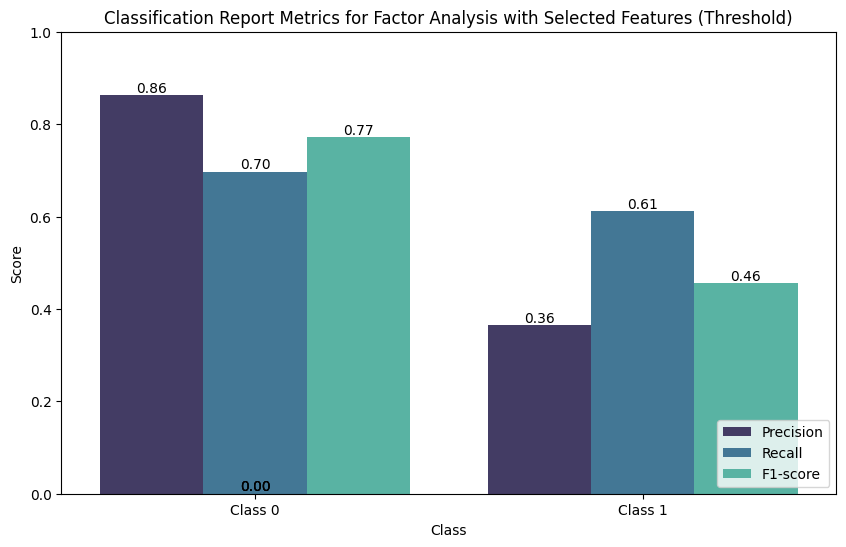

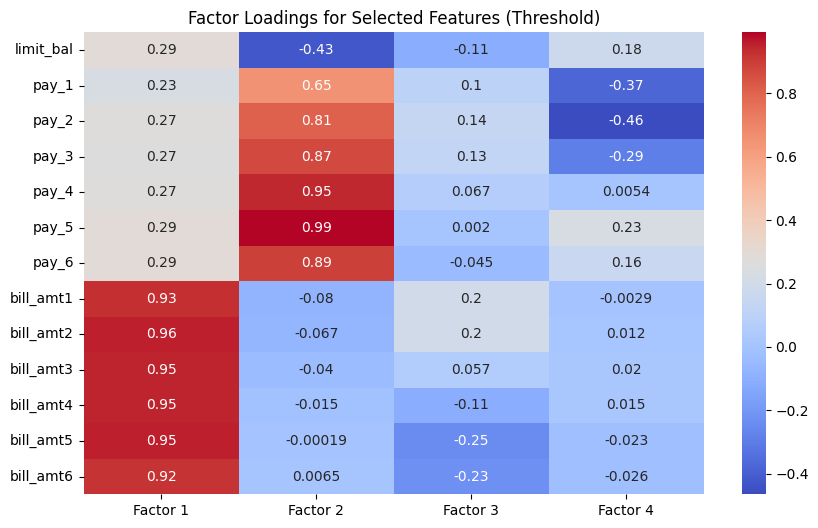

In [23]:
# Step 1: Apply the full feature engineering pipeline and SMOTE (already done)
# X_train_fe, X_test_fe, X_train_res, y_train_res are assumed to be already processed and available

# Step 2: Select numeric and ordinal columns for Factor Analysis
numeric_and_ordinal_features = numeric_features + ['education']  # Including the 'education' ordinal feature
X_train_res_numeric = X_train_res[numeric_and_ordinal_features]
X_test_fe_numeric = X_test_fe[numeric_and_ordinal_features]

# Step 3: Perform Factor Analysis
n_components_fa = min(len(numeric_and_ordinal_features), 4)  # Select a reasonable number of components
fa = FactorAnalysis(n_components=n_components_fa, random_state=42)
X_train_fa_transformed = fa.fit_transform(X_train_res_numeric)
X_test_fa_transformed = fa.transform(X_test_fe_numeric)

# Step 4: Analyze factor loadings
factor_loadings = pd.DataFrame(fa.components_.T, index=numeric_and_ordinal_features, columns=[f'Factor {i+1}' for i in range(n_components_fa)])

# Step 5: Select features with loadings above the threshold
loading_threshold = 0.3  # Set a threshold for factor loadings
important_features = factor_loadings[(factor_loadings.abs() >= loading_threshold).any(axis=1)].index.tolist()

# Print the selected features
print("Selected Features based on Factor Loadings Threshold:", important_features)

# Step 6: Reduce the dataset to only the selected features
X_train_selected = X_train_res[important_features]
X_test_selected = X_test_fe[important_features]

# Step 7: Train the classifier on the selected features
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_selected, y_train_res)

# Step 8: Evaluate on the test set
y_pred_selected = classifier.predict(X_test_selected)
classification_report_selected = classification_report(y_test, y_pred_selected, output_dict=True)
print(classification_report(y_test, y_pred_selected))

# Step 9: Save and plot the results
experiment_results['FactorAnalysis_SelectedFeatures_Threshold'] = classification_report_selected
save_experiment_results(experiment_results, selected_features, 'classification_reports_unsupervised_methods.json')
plot_classification_report_metrics(classification_report_selected, 'Factor Analysis with Selected Features (Threshold)')

# Step 10: Save the selected features to a dictionary and JSON file
selected_features = {}
selected_features['FactorAnalysis_Threshold'] = important_features
with open('selected_features_factor_analysis.json', 'w') as f:
    json.dump(selected_features, f, indent=4)

# Optional: Plot the factor loadings
plt.figure(figsize=(10, 6))
sns.heatmap(factor_loadings.loc[important_features], annot=True, cmap='coolwarm')
plt.title('Factor Loadings for Selected Features (Threshold)')
plt.show()


## Autoencoder

Let’s dive into **Autoencoders**, a type of neural network commonly used for unsupervised learning, dimensionality reduction, and feature extraction.

### What is an Autoencoder?

An **Autoencoder** is a type of artificial neural network designed to learn an efficient representation (encoding) of data. It works by compressing the input into a latent-space representation (encoding) and then reconstructing the output from this encoding. The goal is for the output to be as close to the input as possible.

In simpler terms, an autoencoder tries to learn a compact representation of your data while preserving as much relevant information as possible.

### Structure of an Autoencoder

An autoencoder typically consists of three main parts:

1. **Encoder:**
   - The encoder takes the input data and compresses it into a lower-dimensional representation, called the “bottleneck” or “latent space.” This is where the most important features are captured.
   - It consists of one or more layers that progressively reduce the dimensionality of the input.

2. **Latent Space (Bottleneck):**
   - This is the compressed, dense representation of the input data. The autoencoder is forced to learn how to express the input in fewer dimensions while still retaining important features.
   - The bottleneck acts as a constraint, encouraging the model to capture the most critical patterns.

3. **Decoder:**
   - The decoder takes the compressed latent-space representation and tries to reconstruct the original input from it.
   - It consists of layers that progressively increase the dimensionality back to the original input size.

### How Autoencoders Work

1. **Encoding Phase:**
   - The input data is passed through the encoder, which reduces its dimensionality and produces a compressed version of the data.

2. **Latent Space:**
   - The compressed representation (latent vector) is where the key features of the input data are captured.

3. **Decoding Phase:**
   - The decoder takes the latent vector and attempts to reconstruct the original input from it.

4. **Training Objective:**
   - The autoencoder is trained by minimizing the difference between the input and the reconstructed output. The most common loss function is Mean Squared Error (MSE), which measures how close the reconstructed data is to the original data.

### What are Autoencoders Trying to Achieve?

Autoencoders are designed to learn a compressed, information-rich representation of data. They are particularly useful when you want to:

- **Perform Dimensionality Reduction:** Autoencoders can reduce data to fewer dimensions, similar to PCA, but with more flexibility since they can model non-linear relationships.
- **Learn Feature Representations:** The compressed latent space often contains useful features that can be used in other machine learning tasks.
- **Data Denoising:** Autoencoders can be trained to remove noise from data, making them useful for tasks like image denoising.

### Types of Autoencoders

There are several types of autoencoders, each with different applications:

1. **Vanilla Autoencoder:** The basic autoencoder with a simple encoder-decoder architecture.

2. **Denoising Autoencoder:** Trained to reconstruct clean data from noisy input. It’s commonly used for noise reduction in images or signals.

3. **Sparse Autoencoder:** Encourages sparsity in the latent representation, meaning only a small number of neurons are active. This helps in learning more distinct features.

4. **Variational Autoencoder (VAE):** Instead of learning a deterministic latent vector, VAEs learn a probabilistic distribution, allowing them to generate new data similar to the training data.

5. **Convolutional Autoencoder:** Used for image data. It replaces dense layers with convolutional layers in the encoder and decoder, making it more effective for spatial data like images.

### Strengths and Weaknesses of Autoencoders

**Strengths:**
- **Non-linear Feature Learning:** Unlike PCA, which is limited to linear transformations, autoencoders can capture non-linear relationships in the data.
- **Flexible Architecture:** Autoencoders can be customized with different layers and types (e.g., convolutional, recurrent), making them versatile for various applications.
- **Effective for High-Dimensional Data:** Autoencoders are especially useful when dealing with complex, high-dimensional data like images, where they can extract meaningful patterns.

**Weaknesses:**
- **Requires Large Amounts of Data:** Training autoencoders typically requires a large amount of data to avoid overfitting.
- **Computationally Intensive:** Training deep neural networks, including autoencoders, can be resource-intensive.
- **Not Always Interpretable:** Unlike PCA, which provides clear principal components, the latent features in autoencoders can be harder to interpret.

### When to Use Autoencoders

Autoencoders are especially useful when:
- You have high-dimensional data and want to reduce its dimensionality while preserving important features.
- You need to learn complex, non-linear feature representations.
- You are interested in tasks like data denoising or anomaly detection.

### Example Application: Image Compression

Autoencoders are commonly used for image compression. They take a high-dimensional image, compress it into a much smaller latent-space representation, and then reconstruct it. The reconstructed image may not be perfect, but it is close enough to the original while using far less storage.

### Summary

Autoencoders are powerful neural networks that learn compact, information-rich representations of data by compressing it into a latent space and then reconstructing it. They are useful for dimensionality reduction, feature extraction, and noise reduction. While they share similarities with PCA, autoencoders can model non-linear relationships, making them more versatile for complex datasets.

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1.2133 - val_loss: 1.1186
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8844 - val_loss: 0.9350
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7270 - val_loss: 0.8880
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7097 - val_loss: 0.8693
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7081 - val_loss: 0.8589
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6834 - val_loss: 0.8520
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6873 - val_loss: 0.8467
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6659 - val_loss: 0.8423
Epoch 9/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6624 - val_loss: 0.8384
Epoch 10/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6656 - val_loss: 0.8346
Epoch 11/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6749 - val_loss: 0.8308
Epoch 12/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

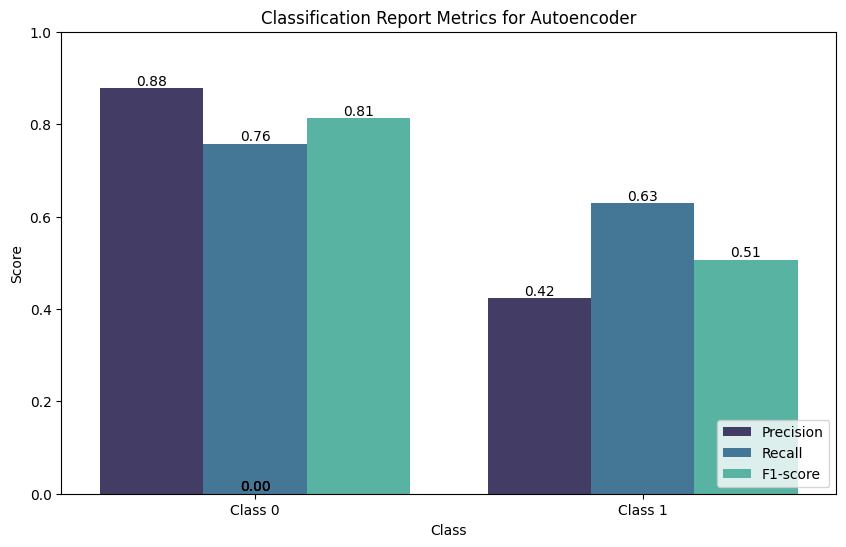

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from loan_data_utils import plot_classification_report_metrics, save_experiment_results

# Step 1: Apply the full feature engineering pipeline and SMOTE (already done)
# X_train_fe, X_test_fe, X_train_res, y_train_res are assumed to be already processed and available

# Step 2: Select numeric columns and the ordinal 'education' column for the autoencoder
numeric_and_ordinal_columns = numeric_features + ['education']
X_train_autoencoder = X_train_res[numeric_and_ordinal_columns]
X_test_autoencoder = X_test_fe[numeric_and_ordinal_columns]

# Step 3: Build the autoencoder architecture
input_dim = X_train_autoencoder.shape[1]
encoding_dim = int(input_dim / 2)  # Adjust the encoding dimension as needed

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Step 4: Train the autoencoder
autoencoder.fit(X_train_autoencoder, X_train_autoencoder,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_autoencoder, X_test_autoencoder))

# Step 5: Extract the encoder part for dimensionality reduction
encoder = Model(inputs=input_layer, outputs=encoded)

# Encode the training and test data
X_train_encoded = encoder.predict(X_train_autoencoder)
X_test_encoded = encoder.predict(X_test_autoencoder)

# Step 6: Convert the encoded data to DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=[f'encoded_{i}' for i in range(X_train_encoded.shape[1])])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=[f'encoded_{i}' for i in range(X_test_encoded.shape[1])])

# Step 7: Recombine the encoded features with the remaining (non-numeric) features
X_train_final = pd.concat([X_train_encoded_df, X_train_res.drop(columns=numeric_and_ordinal_columns).reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test_fe.drop(columns=numeric_and_ordinal_columns).reset_index(drop=True)], axis=1)

# Step 8: Train the final model
classifier = LogisticRegression(max_iter=5000, solver='saga', C=0.1)
classifier.fit(X_train_final, y_train_res)

# Step 9: Evaluate on the test set
y_pred_autoencoder = classifier.predict(X_test_final)
classification_report_autoencoder = classification_report(y_test, y_pred_autoencoder, output_dict=True)
print(classification_report(y_test, y_pred_autoencoder))

# Add the current experiment report to the dictionary
experiment_results = {'Autoencoder': classification_report_autoencoder}

# Save the updated experiment results to the JSON file using the new unified function
save_experiment_results(experiment_results, {}, 'classification_reports_unsupervised_methods.json')

# Plot the classification report metrics
plot_classification_report_metrics(classification_report_autoencoder, 'Autoencoder')


#### Feature Engineering Script for PCA


In [ ]:
script_content=r'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import KBinsDiscretizer, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ------ Ratio Features ------ #

# class RatioFeatures(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         X['bill_ratio'] = X['bill_amt1'] / X['limit_bal']
#         X['pay_ratio'] = X['pay_amt1'] / X['limit_bal']
#         X['age_income_ratio'] = X['age'] / X['limit_bal']
#         return X

class RatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['bill_ratio'] = np.where(X['limit_bal'] != 0, X['bill_amt1'] / X['limit_bal'], 0)
        X['pay_ratio'] = np.where(X['limit_bal'] != 0, X['pay_amt1'] / X['limit_bal'], 0)
        X['age_income_ratio'] = np.where(X['limit_bal'] != 0, X['age'] / X['limit_bal'], 0)
        return X


# ----- Binning Features ------ #

class BinningFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins=5, encode='ordinal', strategy='quantile'):
        # Explicitly store the parameters as class attributes
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)

    def fit(self, X, y=None):
        self.binner.fit(X)
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X)
        return pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.feature_names_in_])


class SelectiveBinningFeaturesOrdinal(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='ordinal', strategy='quantile'):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
        self.other_features = None

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])
        X_binned_df = pd.DataFrame(X_binned, columns=[f'{col}_binned' for col in self.features_to_bin])
        return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)


# ----- One-Hot Binning Features ------ #

class SelectiveBinningFeaturesOneHot(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_bin, n_bins=5, encode='onehot', strategy='quantile', drop_original=True):
        self.features_to_bin = features_to_bin
        self.binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
        self.onehot_encoder = OneHotEncoder(sparse_output=False)
        self.other_features = None
        self.encode = encode
        self.drop_original = drop_original

    def fit(self, X, y=None):
        # Fit only the features that need binning
        self.binner.fit(X[self.features_to_bin])
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Fit the one-hot encoder if needed
        if self.encode == 'onehot':
            self.onehot_encoder.fit(X_binned)

        self.other_features = X.drop(columns=self.features_to_bin).columns.tolist()
        return self

    def transform(self, X):
        X_binned = self.binner.transform(X[self.features_to_bin])

        # Apply one-hot encoding if needed
        if self.encode == 'onehot':
            X_binned = self.onehot_encoder.transform(X_binned)
            bin_columns = [f'{col}_bin_{i}' for col in self.features_to_bin for i in range(X_binned.shape[1] // len(self.features_to_bin))]
        else:
            bin_columns = [f'{col}_binned' for col in self.features_to_bin]

        X_binned_df = pd.DataFrame(X_binned, columns=bin_columns)

        # Decide whether to drop the original features
        if self.drop_original:
            return pd.concat([X_binned_df, X[self.other_features].reset_index(drop=True)], axis=1)
        else:
            return pd.concat([X_binned_df, X.reset_index(drop=True)], axis=1)



# ----- Interaction Features ------ #

class TargetedInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs=None, degree=2, interaction_only=True, include_bias=False):
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.poly = PolynomialFeatures(degree=self.degree, interaction_only=self.interaction_only, include_bias=self.include_bias)
        self.feature_names_in_ = None
        self.interaction_pairs = interaction_pairs  # List of tuples specifying which pairs to interact

    def fit(self, X, y=None):
        if self.interaction_pairs is None:
            self.poly.fit(X)
            self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        else:
            # Limit the features to the interaction pairs
            interaction_columns = [pair[0] for pair in self.interaction_pairs] + [pair[1] for pair in self.interaction_pairs]
            X_selected = X[interaction_columns]
            self.poly.fit(X_selected)
            self.feature_names_in_ = X_selected.columns
        return self

    def transform(self, X):
        if self.interaction_pairs is None:
            X_poly = self.poly.transform(X)
            return pd.DataFrame(X_poly, columns=self.poly.get_feature_names_out(self.feature_names_in_))
        else:
            # Create interaction features for the selected pairs only
            interaction_data = pd.DataFrame(index=X.index)
            for pair in self.interaction_pairs:
                interaction_term = X[pair[0]] * X[pair[1]]
                interaction_data[f"{pair[0]}_{pair[1]}"] = interaction_term
            return interaction_data



class CustomInteractionFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, interaction_pairs):
        self.interaction_pairs = interaction_pairs

    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns if isinstance(X, pd.DataFrame) else [f'feature_{i}' for i in range(X.shape[1])]
        return self

    def transform(self, X):
        interaction_data = pd.DataFrame(index=X.index)
        for pair in self.interaction_pairs:
            if pair[0] in X.columns and pair[1] in X.columns:
                interaction_data[f"{pair[0]}_{pair[1]}"] = X[pair[0]] * X[pair[1]]
            else:
                interaction_data[f"{pair[0]}_{pair[1]}"] = 0  # Default to 0 if interaction is not valid

        return pd.concat([X, interaction_data], axis=1)



# ----- Plot Feature Groups ------ #

def plot_feature_groups(dataframe, feature_groups, hue):
    """
    Plot pairplots for groups of features with color coding by a categorical variable.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the features.
    feature_groups (dict): A dictionary where keys are group names and values are lists of feature names.
    hue (str): The name of the categorical column to color by.
    """
    for group_name, features in feature_groups.items():
        sns.pairplot(dataframe[features + [hue]], hue=hue, palette='magma')
        plt.suptitle(f"Pairplot of {group_name} Features colored by {hue}", y=1.02)
        plt.show()


#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

'''

# Write the script to a file
with open("loan_data_feature_engineering.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_feature_engineering.py")

# Reload script to make functions available for use
import importlib
import loan_data_feature_engineering
importlib.reload(loan_data_feature_engineering)
from loan_data_feature_engineering import *

#### Data Utils Script

In [1]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import joblib
import json
import logging
# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

#--------   Load and Preprocess Data   --------#

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

#--------   Plot Class Distribution   --------#


def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

#--------   Custom Classifier   --------#

# Define a custom classifier to handle class-specific threshold
class ThresholdClassifier(BaseEstimator, TransformerMixin):
    def __init__(self, base_classifier, threshold=0.3):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= self.threshold).astype(int)


#--------   Evaluate and Capture Metrics   --------#

# Function to evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name, experiment_name):
    logger.info(f"Training and evaluating model: {model_name} ({experiment_name})")

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Capture classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract relevant metrics
    metrics = {
        'Model': model_name,
        'Experiment': experiment_name,
        'Recall_0': report['0']['recall'],
        'Precision_0': report['0']['precision'],
        'F1_0': report['0']['f1-score'],
        'Recall_1': report['1']['recall'],
        'Precision_1': report['1']['precision'],
        'F1_1': report['1']['f1-score'],
        'F1_Macro': report['macro avg']['f1-score'],
        'Accuracy': report['accuracy']
    }
    return metrics


# #--------   Plot Classification Report  --------#

# Plotting function with annotations
def plot_classification_report_metrics(report, model_name):
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {model_name}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.show()

def plot_classification_report_thresholds(report, method_name, threshold):
    """
    Function to plot the precision, recall, and f1-score metrics for class 0 and class 1.
    """
    # Extract metrics from the report
    metrics_df = pd.DataFrame({
        'Class': ['Class 0', 'Class 0', 'Class 0', 'Class 1', 'Class 1', 'Class 1'],
        'Metric': ['Precision', 'Recall', 'F1-score', 'Precision', 'Recall', 'F1-score'],
        'Value': [
            report['0']['precision'],
            report['0']['recall'],
            report['0']['f1-score'],
            report['1']['precision'],
            report['1']['recall'],
            report['1']['f1-score']
        ]
    })

    # Plot the metrics
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Value', hue='Metric', data=metrics_df, palette='mako')
    plt.title(f'Classification Report Metrics for {method_name} at Threshold {threshold}')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.show()

#--------   Plot Selected Features  --------#

def plot_selected_features(selected_features, model_name):
    features = list(selected_features.keys())
    importances = list(selected_features.values())
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importances, y=features, palette='viridis')
    plt.title(f'Selected Features and their Importance for {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

#--------   Save Experiment Results  --------#

def save_experiment_results(results, selected_features, filename):
    try:
        # Load existing data if the file already exists
        with open(filename, 'r') as json_file:
            existing_data = json.load(json_file)
    except FileNotFoundError:
        # If the file doesn't exist, start with an empty dictionary
        existing_data = {}

    # Update the existing data with new results
    existing_data.update(results)
    existing_data.update(selected_features)

    # Save the updated data back to the file
    with open(filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)
    print(f"Experiment results saved to {filename}")


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *

Script successfully written to loan_data_utils.py
